Inference of Gene Regulatory Network using Kinetic Ising Model


In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-03-15


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

import os
import sys
sys.path.append('../')

import lib.NetAnalysis as na
# from lib.import_funcs import *
import lib.fun_plotting as fun_plotting
from lib.ml_wrapper import asynch_reconstruction
import lib.figs_funcs as figfunc
import lib.funcs_raster as funcs_raster
import lib.funcs_general as funcs_general
import lib.minibulk_funcs as mb


%load_ext autoreload
%autoreload 2

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

# Initial information

In [3]:
path      = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/" 
path_data = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/DATA/"

In [4]:
# genes of OUR dataset
genes_order = np.loadtxt(path_data+"general_info/genes_order.csv", dtype="str") #selected genes

# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# Genes Classification
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]



# Raw Data

In [5]:
df_raw = pd.read_csv(path_data + "GE_data/imp_genes_raw.csv", header=0, index_col=0, sep=",").reindex(genes_order)
# time_sep = np.loadtxt(path+"GE_data/time_sep.txt", dtype=np.int32)
df_raw.index.name = None

In [6]:
# PST
w_size=150
pst_df = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_3no2CLC_22_09_22.txt',
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"])

pst_df = pst_df.sort_values(by=['pst'])

# riordino dataframe 
column_names = pst_df["barcodes"]
df_raw_pst = df_raw.reindex(columns = column_names)

df_raw_mb_pst = df_raw_pst.rolling(window = w_size, axis=1).mean().dropna(axis=1)
df_raw_mb_pst = pd.DataFrame(df_raw_mb_pst, index=df_raw_pst.index)
df_raw_mb_pst.head(3)


barcodes,GGCGTCAGTCAACGCC,CTCATGCGTCAGGTAG,CTGCCATAGACCGCCT,AGCCAATCAAATCAGA,CGGGTCATCTGGAGAG,TCATTTGTCATCGGGC,AGCATCAAGTACTGGG,ATTCAGGTCGGTTAGT,TCGATTTTCAATCCGA,TATCCTACATAGGTTC,...,TTTGACTTCGCCACTT,GCCATTCTCATTCACT,GAAACCTGTTGTGCCG,CAACCAAAGCCTCACG,TCCTCTTTCGTCCATC,CTAACCCCACAATGCT,CCACACTCACACCAGC,CACGTTCAGCCGAACA,TGATTCTTCCGTTTCG,CTTGATTCACCATTCC
Klf4,1.340000,1.340000,1.353333,1.353333,1.366667,1.406667,1.426667,1.426667,1.426667,1.413333,...,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.213333,0.213333
Klf2,1.233333,1.240000,1.226667,1.226667,1.233333,1.266667,1.260000,1.260000,1.280000,1.286667,...,0.633333,0.626667,0.606667,0.606667,0.580000,0.580000,0.573333,0.573333,0.560000,0.553333
Esrrb,0.240000,0.246667,0.253333,0.246667,0.233333,0.246667,0.260000,0.260000,0.260000,0.260000,...,0.206667,0.206667,0.206667,0.206667,0.206667,0.213333,0.213333,0.220000,0.226667,0.226667


# LogNorm Data

In [7]:
# load the Gene Expression data log normalized: the columns are the cells and the rows are the genes
df_lN = pd.read_csv(path_data + "GE_data/imp_genes_logNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
#remove  the index name
df_lN.index.name=None

df_lN.head(3)

,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1.624017,1.427111,0.000000,0.843545,2.582635,1.825359,0.000000,1.162685,1.708780,0.000000,...,0.0,1.628406,1.075557,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Klf2,1.624017,0.000000,1.436316,1.372344,0.000000,1.430803,2.483172,2.237629,1.093845,1.716736,...,0.0,2.048784,1.075557,0.0,0.0,0.0,2.317913,0.000000,0.0,1.692006
Esrrb,0.000000,1.427111,0.000000,1.372344,1.413292,0.000000,0.000000,1.162685,0.000000,0.000000,...,0.0,1.032705,0.000000,0.0,0.0,0.0,1.219525,0.960339,0.0,0.000000


## Fraction of zeros per gene

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

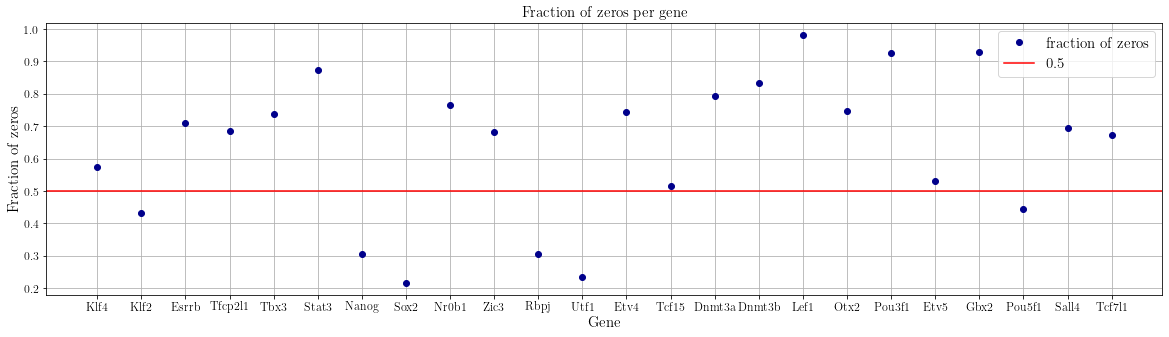

In [8]:
# show with an histogram the number of zero value for each gene
zeros_perGene_frac = np.sum(df_lN==0, axis=1)/df_lN.shape[1]
plt.figure(figsize=(20,5))
plt.plot(zeros_perGene_frac, 'o', color='darkblue', label='fraction of zeros')
# add a line at 0.5
thr_zero = 0.5
plt.axhline(y=thr_zero, color='r', linestyle='-', label=thr_zero)
plt.legend(fontsize=15)
plt.grid(True)
plt.title('Fraction of zeros per gene', fontsize=15)
plt.xlabel('Gene', fontsize=15)
plt.ylabel('Fraction of zeros', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)



## Gene Expression in time

5


(0.0, 1.75)

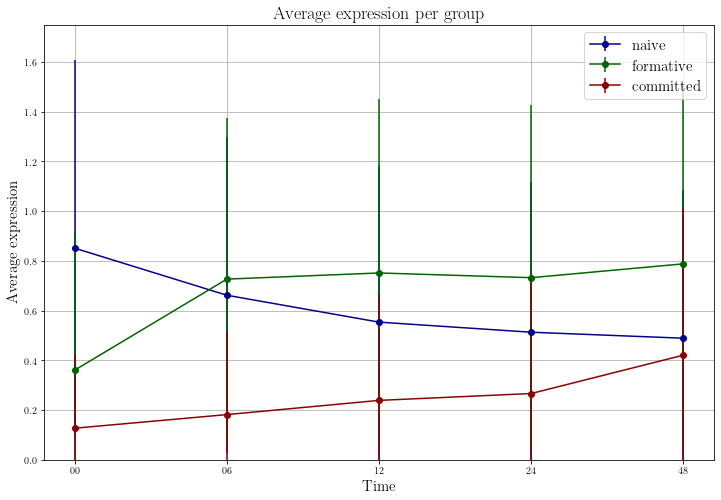

In [9]:
# Separate the different time step dataset
time = np.array(["00", "06","12", "24", "48"])
time_sep = np.loadtxt(path_data+"GE_data/time_sep.txt", dtype=np.int32)
df_00 = df_lN.iloc[:,:time_sep[0]]
df_06 = df_lN.iloc[:, time_sep[0]: np.sum(time_sep[:2])]
df_12 = df_lN.iloc[:, np.sum(time_sep[:2]): np.sum(time_sep[:3])]
df_24 = df_lN.iloc[:, np.sum(time_sep[:3]): np.sum(time_sep[:4])]
df_48 = df_lN.iloc[:, np.sum(time_sep[:4]): np.sum(time_sep[:5])]

df_raw_bulk = pd.concat([df_00.mean(axis=1), df_06.mean(axis=1), df_12.mean(axis=1), df_24.mean(axis=1), df_48.mean(axis=1)], axis=1)
df_raw_bulk.columns=["00", "06","12", "24", "48"]
#average over the group of genes (naive, formative, committed)
df_bulk_groups = pd.DataFrame(index=["naive", "formative", "committed"], columns=df_raw_bulk.columns)
df_bulk_groups.iloc[0,:] = df_raw_bulk.loc[naive].mean(axis=0)
df_bulk_groups.iloc[1,:] = df_raw_bulk.loc[formative].mean(axis=0)
df_bulk_groups.iloc[2,:] = df_raw_bulk.loc[committed].mean(axis=0)
# compute the std for each time step for each group of genes (naive, formative, committed)
df_raw_std = pd.concat([df_00.std(axis=1), df_06.std(axis=1), df_12.std(axis=1), df_24.std(axis=1), df_48.std(axis=1)], axis=1)
df_raw_std.columns=["00", "06","12", "24", "48"]
df_std_groups = pd.DataFrame(index=["naive", "formative", "committed"], columns=df_raw_std.columns)
df_std_groups.iloc[0,:] = df_raw_std.loc[naive].mean(axis=0)
df_std_groups.iloc[1,:] = df_raw_std.loc[formative].mean(axis=0)
df_std_groups.iloc[2,:] = df_raw_std.loc[committed].mean(axis=0)
print(len(df_std_groups.iloc[0,:]))


#plot df_bulk_groups using different colors for each gene group
plt.figure(figsize=(12,8))
plt.errorbar(df_bulk_groups.columns, df_bulk_groups.iloc[0,:], yerr=df_std_groups.iloc[0,:], color='darkblue', label='naive', marker='o')
plt.errorbar(df_bulk_groups.columns, df_bulk_groups.iloc[1,:], yerr=df_std_groups.iloc[1,:], color='darkgreen', label='formative', marker='o')
plt.errorbar(df_bulk_groups.columns, df_bulk_groups.iloc[2,:], yerr=df_std_groups.iloc[2,:], color='darkred', label='committed', marker='o')
plt.legend(fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Average expression', fontsize=15)
plt.title('Average expression per group', fontsize=18)
plt.grid()
plt.ylim([0,1.75])


In [10]:
# # plot the gene expression for each gene in the naive group in time with theis std
# plt.figure(figsize=(12,8))
# # plt.plot(df_raw_bulk.loc[naive].T, color='darkblue', alpha=0.2)
# # do the same with sns to get the gene label
# for ii in range(len(naive)):
#     plt.errorbar(df_bulk_groups.columns,df_raw_bulk.loc[naive[ii]].T, yerr=df_raw_std.loc[naive[ii]].T, label=naive[ii], marker='o')
# plt.legend()
# plt.show()

# # the same for the formative group
# plt.figure(figsize=(12,8))
# for jj in range(len(formative)):
#     plt.errorbar(df_bulk_groups.columns,df_raw_bulk.loc[formative[jj]].T, yerr=df_raw_std.loc[formative[jj]].T, label=formative[jj], marker='o')
# plt.legend()
# plt.show()

# # for the committed group
# plt.figure(figsize=(12,8))
# for kk in range(len(committed)):
#     plt.errorbar(df_bulk_groups.columns,df_raw_bulk.loc[committed[kk]].T, yerr=df_raw_std.loc[committed[kk]].T, label=committed[kk], marker='o')


## Pseudotime

Min pseudotime:  0.0 - Max pseudotime:  38.2221053912345
Number of cells in PST df:  9696


Text(0, 0.5, 'Density')

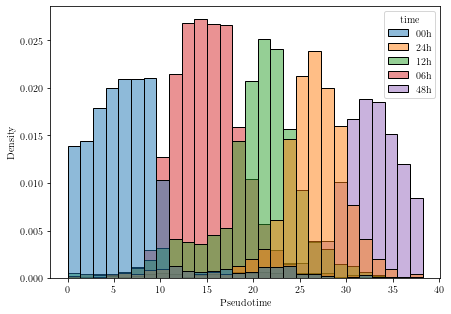

In [11]:
# Load PST Info dataframe: it links cell barcode to pseudotime
PST_df = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_3no2CLC_22_09_22.txt',
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"])

print("Min pseudotime: ", np.min(PST_df["pst"]), "- Max pseudotime: ", np.max(PST_df["pst"]))
print("Number of cells in PST df: ", PST_df.shape[0])

# sorting in ascending values of pseudo-time
PST_df = PST_df.sort_values(by=['pst'])

# PLOT different times separated
plt.figure(figsize=(7,5))
sns.histplot(data=PST_df, x="pst", hue="time", stat="density")
plt.xlabel("Pseudotime")
plt.ylabel("Density")


## PST - reordering

In [12]:
# riordino dataframe : PST
column_names = PST_df["barcodes"]
df_lN_pst = df_lN.reindex(columns = column_names)

pd.DataFrame.to_csv(df_lN_pst, path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv")

# pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv", header=0, index_col=0, sep=",")


## PST + MB

In [13]:
# Window size for Mini-Bulk
mb_wind = 150

# Threshold for half max
thr = 0.5 


In [14]:
# MB
df_lN_mb_pst = pd.DataFrame(df_lN_pst.rolling(window=mb_wind, axis=1).mean().dropna(axis=1), index=df_lN_pst.index)

df_lN_mb_pst.head(3)

# to save
pd.DataFrame.to_csv(df_lN_mb_pst, path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB.csv")


In [15]:

# Set the Flag to save or not the Figures showing the Gene Expression in time (with Mini-Bulk)
saving=False
showing=False
if showing:
    # save the maximum value of each gene
    df_max = np.array(df_lN_mb_pst.max(axis=1))
    for ii in range(len(genes_order)):
        plt.figure(figsize=(10,5))     
        plt.plot(np.linspace(0, len(df_lN_mb_pst.iloc[ii,:]), len(df_lN_mb_pst.iloc[ii,:])), df_lN_mb_pst.iloc[ii,:])
        plt.axhline(y = df_max[ii]*thr, linestyle = 'dotted', color = "darkorange")
        plt.title(genes_order[ii])
        plt.ylim(0, df_max[ii]+0.1*df_max[ii])
        if saving==True:
            plt.savefig("plot/halfmax_50/"+str(ii)+str(genes_order[ii])+"_gene.pdf")
        plt.show()
        print(genes_order[ii],df_max[ii]/2)

# PsiNorm Data

In [16]:
df_pN = pd.read_csv(path_data + "GE_data/imp_genes_PsiNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_pN.index.name = None

df_pN.head(3)


,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1.485415,1.338896,0.000000,0.855192,2.511880,1.881212,0.000000,1.267982,1.684245,0.000000,...,0.0,1.592437,1.025867,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Klf2,1.485415,0.000000,1.338774,1.388465,0.000000,1.479866,2.463433,2.385357,1.075095,1.705082,...,0.0,2.008406,1.025867,0.0,0.0,0.0,2.182156,0.000000,0.0,1.578242
Esrrb,0.000000,1.338896,0.000000,1.388465,1.360576,0.000000,0.000000,1.267982,0.000000,0.000000,...,0.0,1.005610,0.000000,0.0,0.0,0.0,1.123956,0.952262,0.0,0.000000


## Pseudotime

In [17]:
# Load PST Info dataframe for Psi Norm: it links cell barcode to pseudotime
PST_df = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_UMAPno2clcs_23_01_13.txt',
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"])

print("Min pseudotime: ", np.min(PST_df["pst"]), "- Max pseudotime: ", np.max(PST_df["pst"]))
print("Number of cells in PST df: ", PST_df.shape[0])

# sorting in ascending values of pseudo-time
PST_df = PST_df.sort_values(by=['pst'])



Min pseudotime:  0.0 - Max pseudotime:  26.2993780102351
Number of cells in PST df:  9732


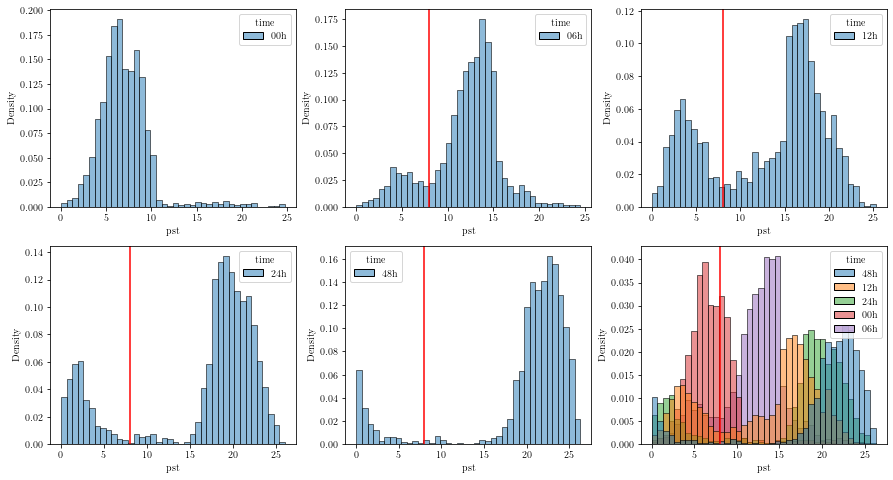

In [18]:
# plot PST for different REAL times 
fig, ax = plt.subplots(2,3,figsize=(15, 8))
sns.histplot(data=PST_df[PST_df["time"] == "00h"], x="pst", hue="time", stat="density", bins=40, ax=ax[0,0])
sns.histplot(data=PST_df[PST_df["time"] == "06h"], x="pst", hue="time", stat="density", bins=40, ax=ax[0,1])
ax[0,1].axvline(x=8, color="r")
sns.histplot(data=PST_df[PST_df["time"] == "12h"], x="pst", hue="time", stat="density", bins=40, ax=ax[0,2])
ax[0,2].axvline(x=8, color="r")
sns.histplot(data=PST_df[PST_df["time"] == "24h"], x="pst", hue="time", stat="density", bins=40, ax=ax[1,0])
ax[1,0].axvline(x=8, color="r")
sns.histplot(data=PST_df[PST_df["time"] == "48h"], x="pst", hue="time", stat="density", bins=40, ax=ax[1,1])
ax[1,1].axvline(x=8, color="r")
sns.histplot(data=PST_df, x="pst", hue="time", stat="density", bins=40, ax=ax[1,2])
ax[1,2].axvline(x=8, color="r")


plt.show()

In [19]:
# Cutting bad inferred PST
PST_df_new = PST_df.drop(PST_df[(PST_df["time"] == "48h") & (PST_df["pst"] < 8.0)].index)
PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "24h") & (PST_df_new["pst"] < 8.0)].index)
PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "06h") & (PST_df_new["pst"] < 8.0)].index)
PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "12h") & (PST_df_new["pst"] < 8.0)].index)

# # Before cutting
# plt.figure(figsize=(7,5))
# sns.histplot(data=PST_df, x="pst", hue="time", stat="density", bins=40)
# plt.xlabel("Pseudotime")
# plt.ylabel("Density")
# # After cutting
# plt.figure(figsize=(7,5))
# sns.histplot(data=PST_df_new, x="pst", hue="time", stat="density", bins=40)
# plt.xlabel("Pseudotime")
# plt.ylabel("Density")

#saving the changed PST_df
PST_df = PST_df_new.copy()

/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_55385/1976356497.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "24h") & (PST_df_new["pst"] < 8.0)].index)
/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_55385/1976356497.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "06h") & (PST_df_new["pst"] < 8.0)].index)
/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_55385/1976356497.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PST_df_new = PST_df_new.drop(PST_df_new[(PST_df["time"] == "12h") & (PST_df_new["pst"] < 8.0)].index)


## PST - reordering

In [20]:
# reordering dataframe using PST
column_names = PST_df["barcodes"]
df_pN_pst = df_pN.reindex(columns = column_names)

df_pN_pst.head(3)

# to save
pd.DataFrame.to_csv(df_pN_pst, path_data + "GE_data/processed/imp_genes_PsiNorm_PST.csv")


## PST + MB

In [21]:
# same parameter as for logNorm, if you want to change, decomment here:
mb_wind = 150    # Window size for Mini-Bulk
thr = 0.5        # Threshold for the half-maximum

# MB implementation for PsiNorm
df_pN_mb_pst = pd.DataFrame(df_pN_pst.rolling(window=mb_wind, axis=1).mean().dropna(axis=1), index=df_pN_pst.index)
df_pN_mb_pst.head(3)

# to save
pd.DataFrame.to_csv(df_pN_mb_pst, path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB.csv")


In [22]:
# Set the Flag to save or not the figures
showing=False
saving=False
if showing:
    # Plotting the half-maximum for each gene
    df_max = np.array(df_pN_mb_pst.max(axis=1))
    for ii in range(len(genes_order)):
        plt.plot(np.linspace(0, len(df_pN_mb_pst.iloc[ii,:]), len(df_pN_mb_pst.iloc[ii,:])), df_pN_mb_pst.iloc[ii,:])
        plt.axhline(y = df_max[ii]*thr, linestyle = 'dotted', color = "darkorange")
        plt.title(genes_order[ii])
        plt.ylim(0, df_max[ii]+0.1*df_max[ii])
        if saving==True:
            plt.savefig("plot/halfmax_50/"+str(ii)+str(genes_order[ii])+"_gene.pdf")
        plt.show()
    #     print(df_max[ii],df_max[ii]/2)

# MB

In [23]:
# raw
df_raw_mb = mb.mov_avg(np.array(df_raw, dtype=int), wind=w_size)
df_raw_mb = pd.DataFrame(df_raw_mb, index=df_raw.index)

# log normalized
df_lN_mb = mb.mov_avg(np.array(df_lN, dtype=int), wind=w_size)
df_lN_mb = pd.DataFrame(df_lN_mb, index=df_lN.index)
pd.DataFrame.to_csv(df_pN_mb_pst, path_data + "GE_data/processed/imp_genes_LogNorm_MB.csv")

# psi normalized
df_pN_mb = mb.mov_avg(np.array(df_pN, dtype=int), wind=w_size)
df_pN_mb = pd.DataFrame(df_pN_mb, index=df_pN.index)
pd.DataFrame.to_csv(df_pN_mb_pst, path_data + "GE_data/processed/imp_genes_PsiNorm_MB.csv")


# Binarization (Half-max)

## LogNorm PST

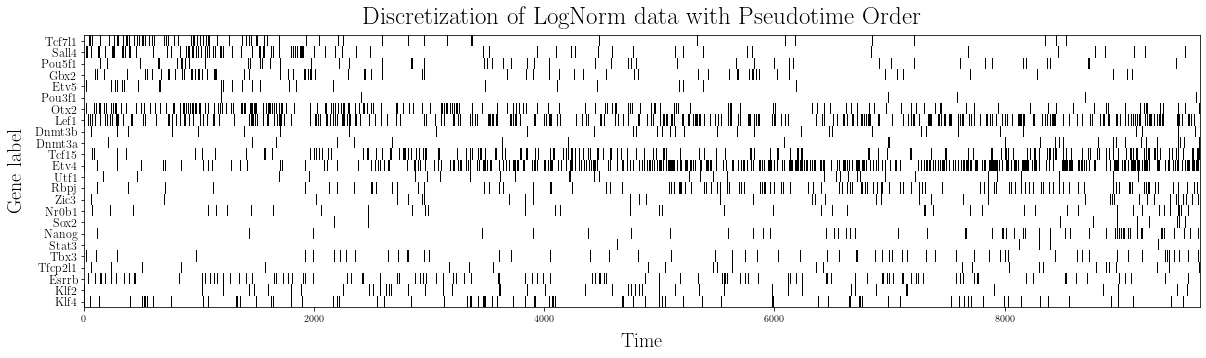

In [24]:
spins_df_lN_pst = funcs_general.binnarization(df_lN_pst, thr=thr, genes_order=genes_order)

fun_plotting.raster_plot(np.array(spins_df_lN_pst), 'Discretization of LogNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()

# to save
pd.DataFrame.to_csv(spins_df_lN_pst, path_data + "GE_data/processed/imp_genes_LogNorm_PST_Spins.csv")


## PsiNorm MB

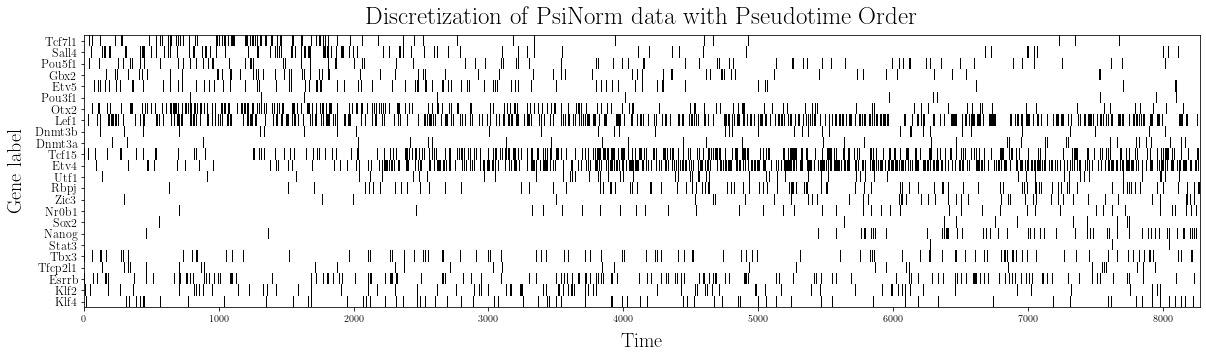

In [25]:
spins_df_pN_pst = funcs_general.binnarization(df_pN_pst, thr=thr, genes_order=genes_order)

fun_plotting.raster_plot(np.array(spins_df_pN_pst), 'Discretization of PsiNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()

# to save
pd.DataFrame.to_csv(spins_df_pN_pst, path_data + "GE_data/processed/imp_genes_PsiNorm_PST_Spins.csv")


## LogNorm PST MB

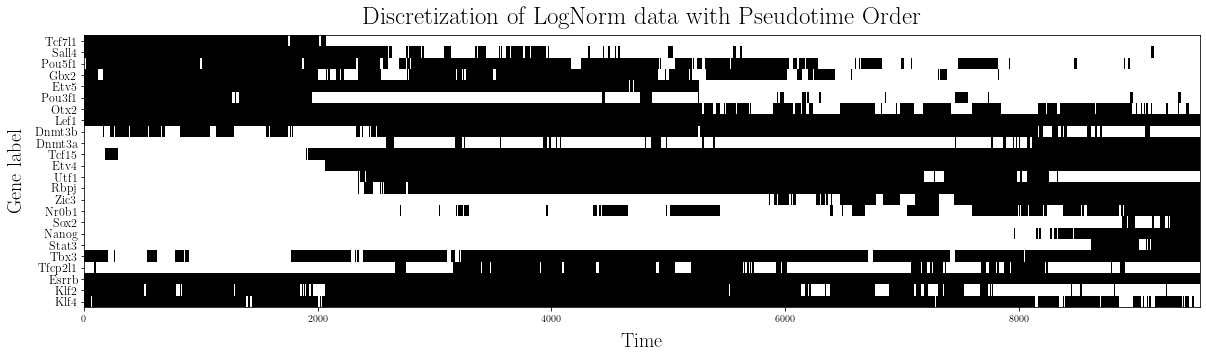

In [26]:
spins_df_lN_mb_pst = funcs_general.binnarization(df_lN_mb_pst, thr=thr, genes_order=genes_order)

fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst), 'Discretization of LogNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()

# to save
pd.DataFrame.to_csv(spins_df_lN_mb_pst, path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins.csv")


## PsiNorm PST MB

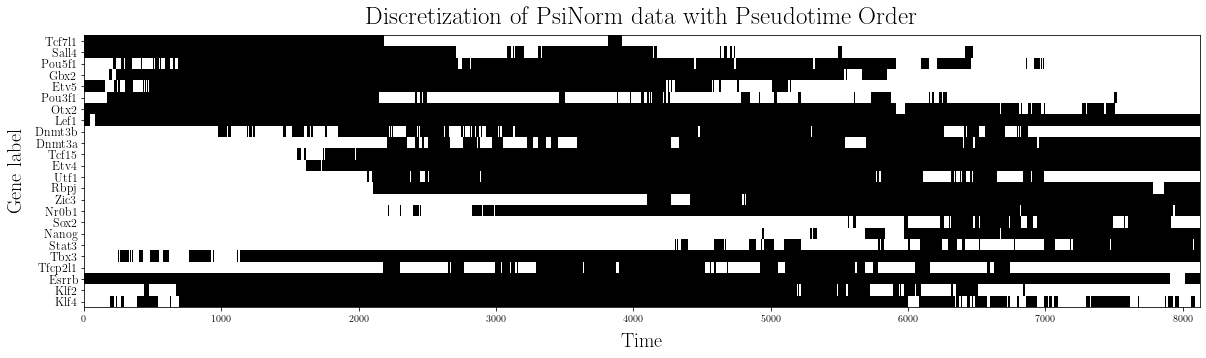

In [27]:
spins_df_pN_mb_pst = funcs_general.binnarization(df_pN_mb_pst, thr=thr, genes_order=genes_order)
fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst), 'Discretization of PsiNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()

# to save
pd.DataFrame.to_csv(spins_df_pN_mb_pst, path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins.csv")


# Randomization

In [28]:
Ntest = 50

## LogNorm PST

In [29]:
N_rows = spins_df_lN_pst.shape[0]
N_cols = spins_df_lN_pst.shape[1]

# Linearize
val_rnd = np.reshape(np.array(spins_df_lN_pst), (N_cols*N_rows))

# reshuflle for Ntest times
spins_df_lN_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) # Reshape to the original shape
    trial_long = pd.DataFrame(val_rnd_matx)

    # Save the shuffled DataFrame
    spins_df_lN_pst_shuffle[ii,:,:] = trial_long
    
# to save
np.save(path_data + "GE_data/processed/imp_genes_LogNorm_PST_Spins_RND50Test.npy", spins_df_lN_pst_shuffle)


## PsiNorm PST

In [30]:
N_rows = spins_df_pN_pst.shape[0]
N_cols = spins_df_pN_pst.shape[1]

# Linearize
val_rnd = np.reshape(np.array(spins_df_pN_pst), (N_cols*N_rows))

# reshuflle for Ntest times
spins_df_pN_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) # Reshape to the original shape
    trial_long = pd.DataFrame(val_rnd_matx)

    # Save the shuffled DataFrame
    spins_df_pN_pst_shuffle[ii,:,:] = trial_long
    
# to save
np.save(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_Spins_RND50Test.npy", spins_df_pN_pst_shuffle)


## LogNorm PST MB

In [31]:
N_rows = spins_df_lN_mb_pst.shape[0]
N_cols = spins_df_lN_mb_pst.shape[1]

# Linearize
val_rnd = np.reshape(np.array(spins_df_lN_mb_pst), (N_cols*N_rows))

# reshuflle for Ntest times
spins_df_lN_mb_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) # Reshape to the original shape
    trial_long = pd.DataFrame(val_rnd_matx)

    # Save the shuffled DataFrame
    spins_df_lN_mb_pst_shuffle[ii,:,:] = trial_long
    
# to save
np.save(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins_RND50Test.npy", spins_df_lN_mb_pst_shuffle)


## PsiNorm PST MB

In [32]:
N_rows = spins_df_pN_mb_pst.shape[0]
N_cols = spins_df_pN_mb_pst.shape[1]

# Linearize
val_rnd = np.reshape(np.array(spins_df_pN_mb_pst), (N_cols*N_rows))

# reshuflle for Ntest times
spins_df_pN_mb_pst_shuffle = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    np.random.shuffle(val_rnd) # Random reshuffle of the binnarized GE data
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) # Reshape to the original shape
    trial_long = pd.DataFrame(val_rnd_matx) # Convert to DataFrame

    # Save the shuffled DataFrame
    spins_df_pN_mb_pst_shuffle[ii,:,:] = trial_long     # Save the shuffled DataFrame
    
    
# to save
np.save(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins_RND50Test.npy", spins_df_pN_mb_pst_shuffle)



In [34]:
check=True
if check:
    # Check the reshuffle
    print(funcs_general.check_shuffle(spins_df_lN_pst_shuffle, Ntest))
    print(funcs_general.check_shuffle(spins_df_pN_pst_shuffle, Ntest))
    print(funcs_general.check_shuffle(spins_df_lN_mb_pst_shuffle, Ntest))
    print(funcs_general.check_shuffle(spins_df_pN_mb_pst_shuffle, Ntest))
    
    # zero expected if everithing is working fine

1.0
1.0
0.0
0.0


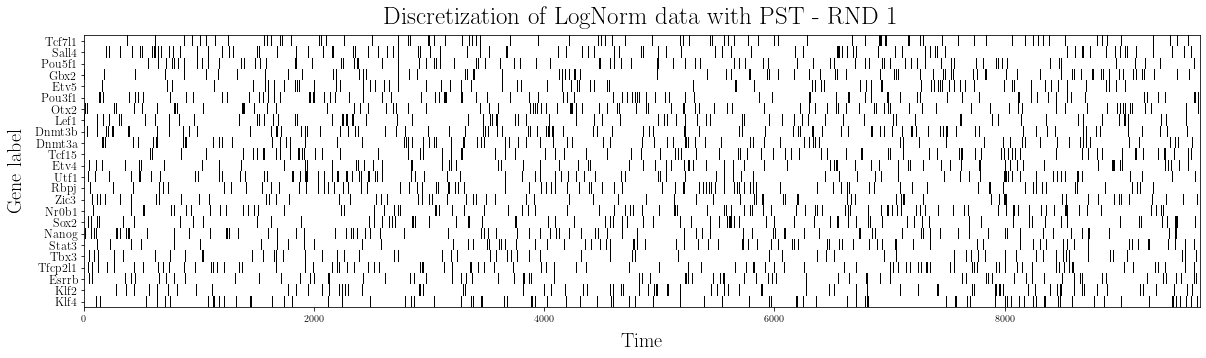

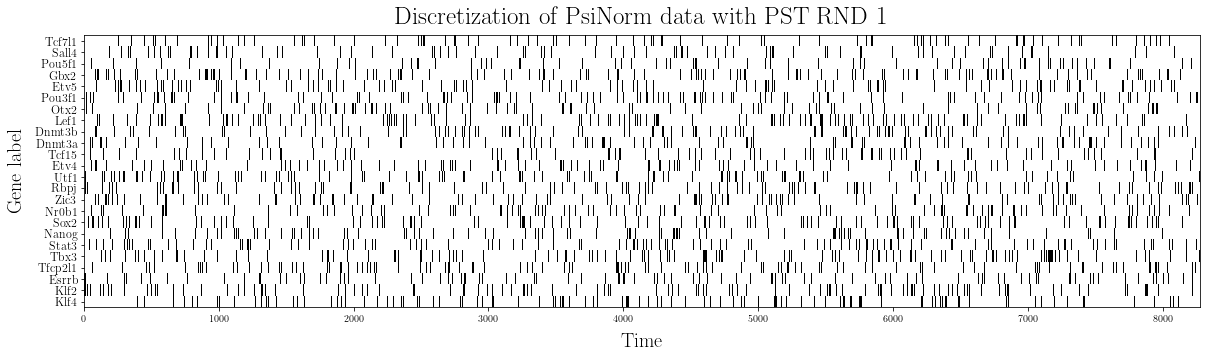

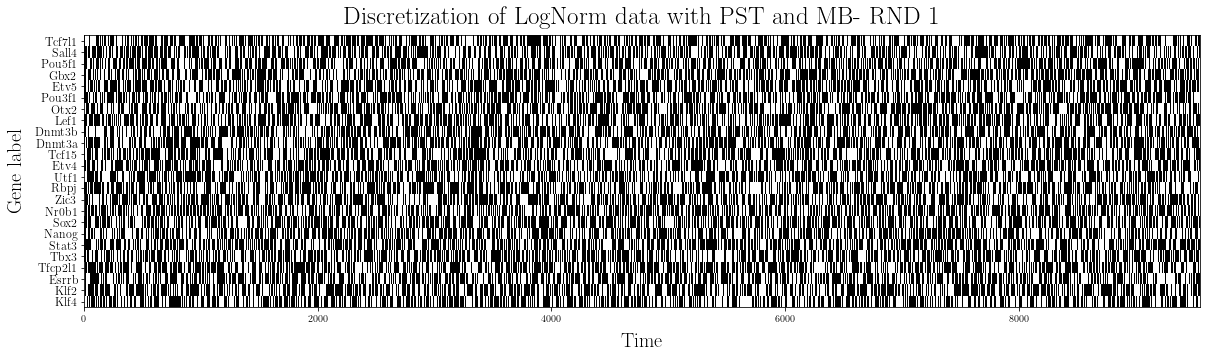

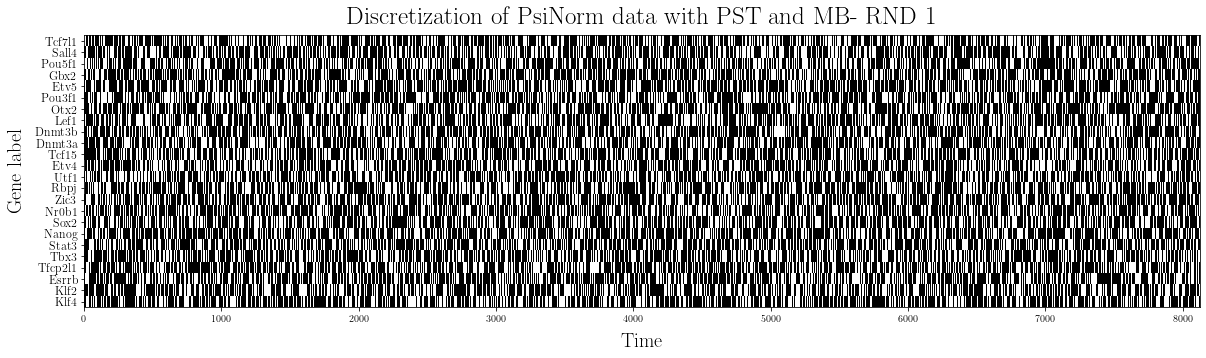

In [35]:
show = True
if show:
    for ii in range(0, Ntest, 60):
            fun_plotting.raster_plot(np.array(spins_df_lN_pst_shuffle[ii,:,:]), 'Discretization of LogNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show() 
            fun_plotting.raster_plot(np.array(spins_df_pN_pst_shuffle[ii,:,:]), 'Discretization of PsiNorm data with PST RND '+str(ii+1), 1, genes_order[::-1])
            plt.show() 
            fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst_shuffle[ii,:,:]), 'Discretization of LogNorm data with PST and MB- RND '+str(ii+1), 1, genes_order[::-1])
            plt.show()    
            fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst_shuffle[ii,:,:]), 'Discretization of PsiNorm data with PST and MB- RND '+str(ii+1), 1, genes_order[::-1])
            plt.show() 

